In [1]:
import pandas as pd
from gensim.models import FastText


C:\Users\Andreas\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_hdf("../datasets/AskMen.h5", key="AskMen")

In [3]:
model_sent = FastText.load("../models/subreddit_level/fasttext_AskMen_senti.bin")
#model_weat = FastText.load("models/subreddit_level/fasttext_TwoXChromosomes_weat.bin")

In [4]:
NRC = pd.read_csv('../datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None, names=["Words", "valence", "arousal", "dominance"])
#NRC.columns = ["Words", "valence", "arousal", "dominance"]

In [5]:
token_list = df["token_list"].tolist()
flatlist = [item for sublist in token_list for item in sublist]

In [6]:
flatlist_2 = [item for sublist in flatlist for item in sublist]

In [7]:
len(list(set(flatlist_2)))

139022

In [8]:
len(flatlist)

3947569

In [47]:
def identify_weigths(flat_list):
    from collections import Counter
    female=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
    male=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him"]  

    tokens = [item for sublist in flat_list for item in sublist]
    term_list_woman = []
    for i in tokens:
        if i in female:
            term_list_woman.append(i)
    counter = Counter(term_list_woman)
    
    liste_woman = []
    weights = []
    
    for i in counter:
        if counter[i] > 100:
            liste_woman.append(i)
            weights.append(counter[i])
            
    term_list_man = []
    for i in tokens:
        if i in male:
            term_list_man.append(i)
    counter = Counter(term_list_man)
    
    liste_man = []
    weights_man = []
    
    for i in counter:
        if counter[i] > 100:
            liste_man.append(i)
            weights_man.append(counter[i])
    
    return [liste_woman, weights], [liste_man, weights_man] 

In [48]:
woman_terms_freq, man_terms_freq = identify_weigths(flatlist)

In [49]:
woman_terms_freq, man_terms_freq

([['her', 'she', 'girl', 'woman', 'female', 'sister', 'daughter', 'hers'],
  [96733, 392445, 68616, 213178, 17213, 6729, 6680, 1130]],
 [['man', 'boy', 'his', 'he', 'male', 'brother', 'son', 'him'],
  [197318, 11399, 61639, 239269, 18498, 8115, 6593, 196]])

In [50]:
def calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model, NRC, n_words):
    import numpy as np
    word_vectors = model.wv
    centroid_woman = np.ma.average([word_vectors[w] for w in woman_terms_freq[0]], weights= woman_terms_freq[1] ,axis=0)

    vector_woman = word_vectors.similar_by_vector(centroid_woman,topn=n_words)
    
    liste_woman = []
    for i in vector_woman:
        liste_woman.append(i[0])
    
    print("Top 10 (woman)", liste_woman[:10])
    
    intersection_woman = list(set(liste_woman) & set(NRC["Words"]))
    
    intersection_woman_ordererd = []
    for i in vector_woman:
        if i[0] in intersection_woman:
            intersection_woman_ordererd.append(i[0])
    
    df_intersection_woman = pd.DataFrame(intersection_woman_ordererd, columns=["Words"])
    df_intersection_woman = df_intersection_woman.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    
    centroid_man = np.ma.average([word_vectors[w] for w in man_terms_freq[0]], weights= man_terms_freq[1] ,axis=0)

    vector_man = word_vectors.similar_by_vector(centroid_man,topn=n_words)
    
    
    liste_man = []
    for i in vector_man:
        liste_man.append(i[0])
    
    print("Top 10 (man)", liste_man[:10])
    
    intersection_man = list(set(liste_man) & set(NRC["Words"]))
    
    intersection_man_ordererd = []
    for i in vector_man:
        if i[0] in intersection_man:
            intersection_man_ordererd.append(i[0])
    
    df_intersection_man = pd.DataFrame(intersection_man_ordererd, columns=["Words"])
    df_intersection_man = df_intersection_man.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    return df_intersection_woman, df_intersection_man, liste_woman, liste_man

In [51]:
df_NRC_woman , df_NRC_man , liste_woman, liste_man= calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model_sent, NRC, 500)


Top 10 (woman) ['she', 'girl', 'her', 'girlfriend', 'gf', 'boyfriend', 'would', 'woman', 'guy', 'wife']
Top 10 (man) ['he', 'guy', 'man', 'his', 'boyfriend', 'would', 'bloke', 'girlfriend', 'bf', 'secretly']


In [52]:
df_NRC_man.sort_values("valence").head()

,Words,valence,arousal,dominance
122,afraid,0.010,0.775,0.245
146,threatened,0.052,0.928,0.354
167,freak,0.052,0.839,0.464
179,penniless,0.062,0.316,0.083
141,cocksucker,0.083,0.764,0.339


In [53]:
df_NRC_man.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
208,sexy,0.865,0.945,0.802
79,fuck,0.198,0.930,0.446
146,threatened,0.052,0.928,0.354
173,frantically,0.375,0.898,0.735
187,mad,0.219,0.873,0.277


In [54]:
df_NRC_man.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
211,audacity,0.760,0.755,0.916
151,manhood,0.625,0.735,0.858
60,legit,0.747,0.427,0.849
130,father,0.812,0.333,0.824
93,able,0.786,0.500,0.810


In [55]:
df_NRC_woman.sort_values("valence").head()

,Words,valence,arousal,dominance
180,hell,0.020,0.918,0.565
57,freak,0.052,0.839,0.464
150,reject,0.060,0.647,0.370
157,upset,0.071,0.680,0.330
200,trouble,0.135,0.811,0.452


In [56]:
df_NRC_woman.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
141,bang,0.265,0.951,0.740
197,excite,0.823,0.950,0.668
51,sexy,0.865,0.945,0.802
165,sex,0.803,0.939,0.704
216,excited,0.908,0.931,0.709


In [57]:
df_NRC_woman.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
202,audacity,0.760,0.755,0.916
193,goddess,0.865,0.560,0.888
198,decide,0.656,0.540,0.855
83,legit,0.747,0.427,0.849
103,able,0.786,0.500,0.810


In [58]:
print(df_NRC_man["valence"].var(),df_NRC_man["arousal"].var(),df_NRC_man["dominance"].var() )

0.04683430159617279 0.029098507444335155 0.026439530246803167


In [59]:
print(df_NRC_woman["valence"].var(),df_NRC_woman["arousal"].var(),df_NRC_woman["dominance"].var() )

0.046967980487213644 0.03674362820668202 0.025606007110249275


In [60]:
def check_normal_dist(df,subject, gender):
    import scipy.stats as stats
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from scipy import stats

    z =  (df["valence"]- np.mean(df[subject]))/np.std(df[subject])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot ({gender})")
    plt.show()
    #ks2 = stats.ks_2samp(df_NRC_woman["valence"], df_NRC_man["valence"])
    #print("ks2", ks2)
    print("kolmogorv", stats.kstest(df[subject],
               stats.norm.cdf))

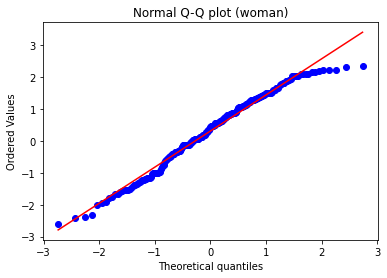

kolmogorv KstestResult(statistic=0.5618306706048808, pvalue=6.750658498079827e-67)


In [61]:
check_normal_dist(df_NRC_woman, "arousal", "woman")

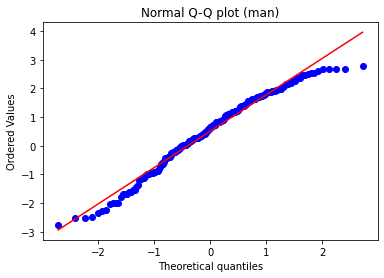

kolmogorv KstestResult(statistic=0.5662484161918939, pvalue=1.0182752511871578e-64)


In [62]:
check_normal_dist(df_NRC_man, "arousal","man")

In [63]:
def apply_ttest_ind(df_1,df_2,score_type):
    from scipy.stats import ttest_ind
    from scipy.stats import levene 
    import math
    import statistics
   
    stat, p = ttest_ind(df_1[score_type].tolist(),df_2[score_type].tolist(), nan_policy="omit", alternative="two-sided",equal_var=False )#, equal_var=False)
    alpha = 0.05
    print("Statistics=%3f, p=%.3f" % (stat, p))
    if p < alpha:
        print("Different distributions (reject H0)")
    else:
        print("Same distribution (fail to reject H0)")
    if p < alpha:
        d = (df_1[score_type].mean() - df_2[score_type].mean())/math.sqrt(((df_1[score_type].var() + df_2[score_type].var())/2))
        
        print(d, "Cohens D")
    print(len(df_1), len(df_2))

In [64]:
apply_ttest_ind(df_NRC_woman, df_NRC_man,"arousal")
apply_ttest_ind(df_NRC_woman, df_NRC_man,"valence")
apply_ttest_ind(df_NRC_woman, df_NRC_man,"dominance")

welsh
Statistics=1.934686, p=0.054
Same distribution (fail to reject H0)
223 212
welsh
Statistics=0.258260, p=0.796
Same distribution (fail to reject H0)
223 212
welsh
Statistics=0.656478, p=0.512
Same distribution (fail to reject H0)
223 212


In [65]:
print(df_NRC_man["valence"].mean(),df_NRC_man["arousal"].mean(),df_NRC_man["dominance"].mean() )
print(df_NRC_woman["valence"].mean(),df_NRC_woman["arousal"].mean(),df_NRC_woman["dominance"].mean() )

0.5704198113207541 0.48319339622641516 0.4984764150943397
0.5757847533632288 0.5168161434977581 0.5086367713004487
